This notebook is used to get the explanation of GPT4-o on the concept circuit.
Please run the run.sh first and save the result in the "../results/" directory.

In [ ]:
from openai import OpenAI
import base64
from dotenv import load_dotenv
import os
from torchvision.transforms import functional
from PIL import Image
import torch
import io
from utils import get_neu_id_top_concepts
import random

def encode_image(image_tensor):
    # Convert tensor to PIL Image
    def normalize(x: torch.Tensor):
        x = x - x.min()
        x = x / x.max()
        return x
    image = functional.to_pil_image(normalize(image_tensor))
    # Convert PIL Image to bytes
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    img_bytes = buffered.getvalue()
    # Encode bytes to base64
    return base64.b64encode(img_bytes).decode('utf-8')

load_dotenv()

client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY'),
)

def chat_gpt(prompt, role_description, model = "gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        messages=[
                {"role": "system", "content": role_description},
                {"role": "user", "content": prompt}
            ],
        
    )
    return response.choices[0].message.content.strip() # type: ignore

def chat_gpt_image(prompt, role_description, base64_images, model = "gpt-4o"):
    content = [
        {
            "type": "text",
            "text": prompt
        }
    ]
    for i, image in enumerate(base64_images):
        content.append({
            "type": "text",
            "text": "index: " + str(i)
        })
        content.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image}"
            }
        })
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": role_description},
            {"role": "user", "content": content} # type: ignore
        ]
    )
    return response.choices[0].message.content.strip() # type: ignore

def chat_gpt_groups_images(prompt, role_description, groups, model = "gpt-4o"):
    content = [
        {
            "type": "text",
            "text": prompt
        }
    ]
    for i, group in enumerate(groups):
        content.append({
                "type": "text",
                "text": f"group number: {i+1}"
            })
        for image in group:
            content.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image}"
                }
            })
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": role_description},
            {"role": "user", "content": content}, # type: ignore
        ]
    )
    return response.choices[0].message.content.strip() # type: ignore

We define the prompt.

In [2]:
role_description = "Act as an Image Captioning Language Model."
prompt = """
# Role Definition:
Act as an Image Captioning Language Model. 

# Core Responsibilities:
- Analyze a set of similar images to identify common features.
- Generate descriptive captions that highlight these common features.
- You must adapt to detect both simple and complex features.

# Important notes:
- You don't have to generate captions for every image, focus on the common features.
- Outliers exist in the images, you could ignore them if they are not relevant to the common theme.
- You should describe the images with objective visual features, not subjective (like powerful or beautiful or scary etc., because these are only your opinion).
- You should only describe visual features, not the context or the story behind the images.
- You should keep a succinct caption, keep it one or two sentences long, that only describe a few most common features.

# Role Summary:
Your role is to provide accurate and coherent captions for a set of similar images by identifying and describing common features. These features can range from simple elements like edges and colors to complex patterns such as a specific object in a particular setting.
"""

answer_form_single_concept = '''
# Answer form:
- Common features: <<a list of features>>
- Caption: <<your caption in one or two sentences>>
'''

answer_form_multiple_concepts = '''
# Key note of the input:
- There are many different groups of images, make sure you get the number of groups right.
- Each group of images has a common feature.
- The higher level feature is the first group.
- Other groups are lower level features that combine to form the higher level feature of the first group.

# Key note of the output:
- You should not only focus on the common features of the images but also describe how the features from the lower level groups combine to form the higher-level feature of the first group.
- You should focus on the common features that shared among both the high and low level.

# Step by step:
- Find the lists of common features in Group 2,...,N.
- For each feature from those lists: match it with the features in Group 1.
- Some of the features in the lists might have no matches: they might be combined with others to form new features, match the features in Group 1 with some simple combination of the features in Group 2,...,N (e.g. blue and green -> blue-green, multiple curve orientations -> a circle, two edges with different orientations -> an angle, etc.).
- If you don't find any visual features that match, please don't describe features that is not presented, instead, you can say "There is no matches".
- From the matched features, derive the common features in Group 1. 
- Generate caption for Group 1.

# Answer form:
- Group 1 Common Features: <<list of common features>>
- Group 2 Common Features: <<list of common features>>
...
- Group N Common Features: <<list of common features>>
- Feature Evolution:
    - Group 2: has feature A - match feature A in Group 1 (for Group 2 to N, if there is no matches, please say "There is no matches")
    - ...
    - Group N: has feature B - match feature B in Group 1
- Caption: <<one or two sentences capturing the common features and their evolution>>
'''


Load our framework.

In [ ]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from NeurFlow import Framework

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

directory = "../results/"
model_name = "resnet50"
label = 309
tau = 16
path = directory+ f"store_{model_name}_label{label}_tau{tau}.pth"

store = torch.load(path, map_location="cpu", weights_only=False)
FW = store["FW"]
layers = store["layers"]
del store

print(layers)


/home/tueminh.cao/miniconda3/envs/neurflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
['fc', 'layer4.2', 'layer4.1', 'layer4.0', 'layer3.5', 'layer3.4', 'layer3.3', 'layer3.2', 'layer3.1', 'layer3.0', 'layer2.3']


We find what concepts at the previous layer have strong impacts on an upper layer's concept.
The dictionary have the structure: {lower_layer_concept_id: score}.

========= Layer: 9 Cluster_label: 1 =========
Feature map: 617
Label: 1


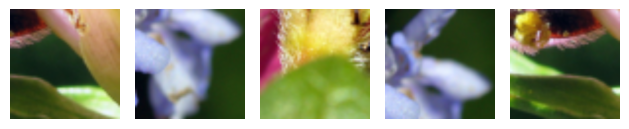

Top concepts of 1 are: {2: 2.531093912630474, 4: 1.456303125001871}
========= Top concept: 2 =========
Feature map: 611
Label: 1


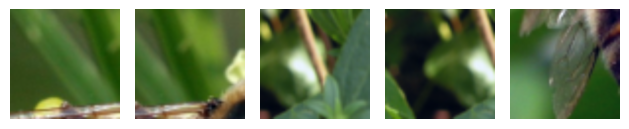

========= Top concept: 4 =========
Feature map: 1261
Label: 1


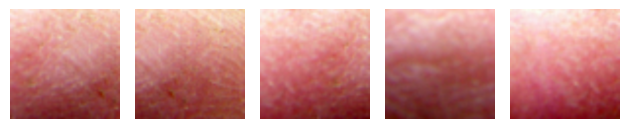

{617: np.int64(1)}
defaultdict(<class 'list'>, {611: [np.int64(1)], 1261: [np.int64(1)]})


In [ ]:
upper_layer = 9             # upper layer index
concept_id = 1              # concept id
num_top_concepts = 2        # number of top concepts
upper_num_cluster = 3       # number of clusters in the upper layer
lower_num_cluster = 5       # number of clusters in the lower layer
specify_cluster = True      # specify cluster, if False, the num_cluster will be self-determined
num_top_vecs = 10           # number of representative vectors
fm_id_cur, fm_id_prev = get_neu_id_top_concepts(
    FW, upper_layer, upper_num_cluster, lower_num_cluster, concept_id, num_top_concepts, specify_cluster, num_top_vecs
)
print(fm_id_cur)
print(fm_id_prev)

We get the caption of GPT4-o on the concept circuit.

In [ ]:
'''
Get caption of chatgpt
'''
target_fm, target_label = list(fm_id_cur.items())[0]
input_imgs = [list(encode_image(FW.concept_data[idx]) for idx in FW.get_top_images_for_labels(upper_layer, target_fm)[target_label])]
for fm, labels in fm_id_prev.items():
    for label in labels:
        input_imgs.append(list(encode_image(FW.concept_data[idx]) for idx in FW.get_top_images_for_labels(upper_layer-1, fm)[label]))
print(chat_gpt_groups_images(prompt + answer_form_multiple_concepts, role_description, input_imgs))

We want to run a little experiment to test: whether LLM can pick the right images based on the caption.
We sample similar images of the concept and random images, then shuffle them up.
We ask GPT4-o to pick the images related to the caption.

In [ ]:
'''
Test the accuracy of the caption
'''
end = 9
cluster_label = 0
n_cluster = 3
specify_cluster = True
num_top_vecs=3

related_imgs = []
dict_cluster_concepts, _ = FW.cluster_concept_vectors(end, n_cluster if specify_cluster else None, num_top_vecs=num_top_vecs, max_n_clusters=100)
for fm, temp_dict in dict_cluster_concepts.items():
    for label, temp_cluster_label in temp_dict.items():
        if temp_cluster_label == cluster_label:
            related_imgs.extend(FW.get_critical_neurons(end, fm)[label])

related_imgs = list(set([index for index in related_imgs])) 
     
max_index = FW.concept_data.shape[0]
random_indices = []
while len(random_indices) != len(related_imgs):
    index = random.randint(0, max_index-1)
    if index not in related_imgs:
        random_indices.append(index)
        
print("Idx of images of concept:", related_imgs)
print("Random idx", random_indices)

Idx of images of concept: [384, 1668, 646, 791, 151, 924, 158, 1951, 1824, 1185, 673, 1699, 425, 432, 690, 818, 1088, 707, 1097, 202, 974, 729, 476, 1760, 1637, 617, 1261, 1518, 883, 895]
Random idx [419, 1423, 2180, 1414, 1976, 642, 2397, 1965, 1569, 2400, 399, 1605, 197, 568, 1038, 1398, 885, 584, 2279, 512, 2183, 2124, 1373, 2634, 1018, 822, 397, 1669, 248, 2063]


Now, you can paste the caption to the "previous_description" and see the accuracy of GPT based on the caption.

In [ ]:
# copy the caption here
previous_description = "Close-up of a shark's face, showing its teeth, eyes, and mouth."

# define the question to test 
role = "You are a careful image analyzer that can detect the right images based on the description."
question = f'''
Can you find {len(related_imgs)} images that are related to the description "{previous_description}"?
Answer in the form of a list of image indices, e.g., [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
'''
shuffeled_list = related_imgs+random_indices
random.shuffle(shuffeled_list)
input_imgs = [encode_image(FW.concept_data[idx]) for idx in shuffeled_list]
response = chat_gpt_image(question, role_description, input_imgs)

import re
def extract_numbers_from_string(s):
    """
    Extracts all numbers from a string and adds them to a list.
    Supports both integers and floating-point numbers.
    
    :param s: Input string
    :return: List of numbers (as floats if they contain a decimal point, otherwise as ints)
    """
    numbers = re.findall(r'\d+\.\d+|\d+', s)  # Match integers and decimal numbers
    return [float(num) if '.' in num else int(num) for num in numbers]

image_idx_from_response = extract_numbers_from_string(response)
picked_indices = [shuffeled_list[index] for index in image_idx_from_response] # type: ignore
print("Accuracy from caption:", len(set(picked_indices).intersection(set(related_imgs)))/len(related_imgs)*100.0)